In [1]:
import yfinance as yf
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
eth_data = yf.download('ETH-USD', start='2023-01-01', end='2024-01-01')

eth_data = eth_data[['Open', 'High', 'Low', 'Close', 'Volume']]
eth_data.dropna(inplace=True)

eth_data.to_csv("ethereum_price_data.csv")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


**EDA & Visualizations for ETH Data**

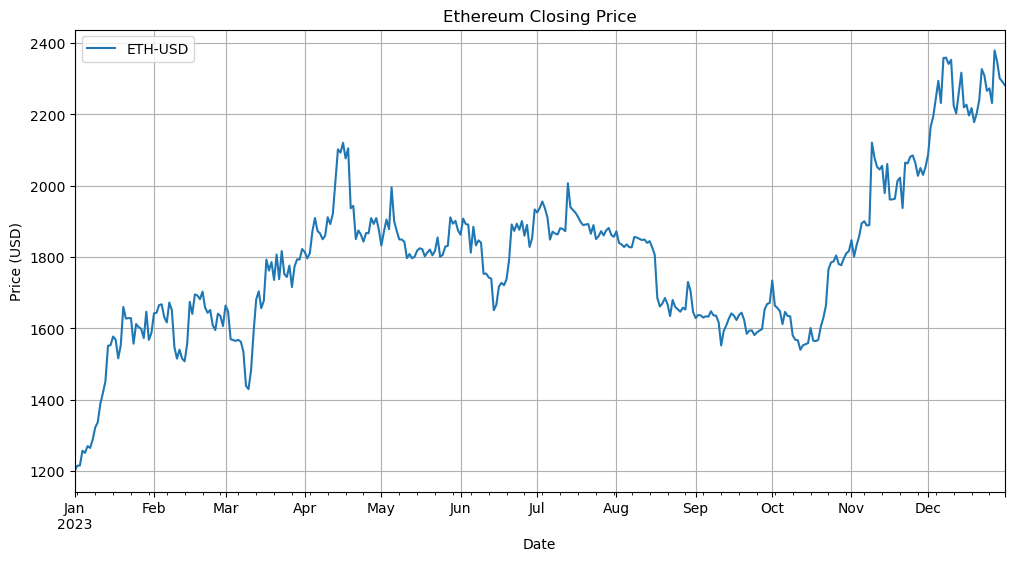

In [3]:
eth_data['Close'].plot(figsize=(12,6), title='Ethereum Closing Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.savefig("eth_closing_price.png")
plt.show()

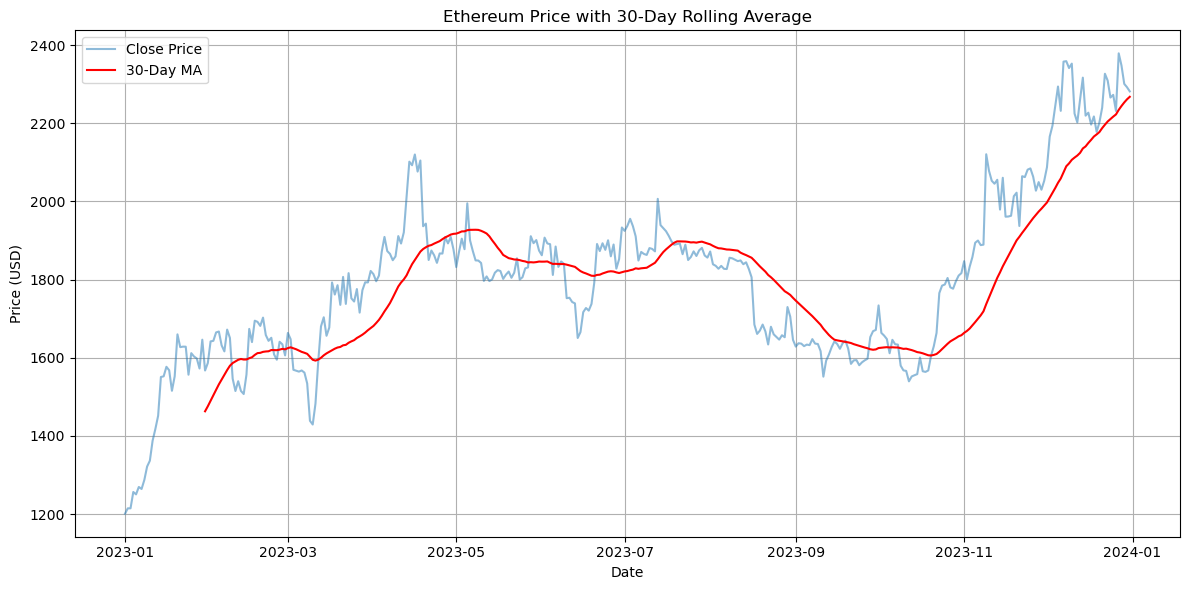

In [4]:
eth_data['30D MA'] = eth_data['Close'].rolling(window=30).mean()

plt.figure(figsize=(12, 6))
plt.plot(eth_data['Close'], label='Close Price', alpha=0.5)
plt.plot(eth_data['30D MA'], label='30-Day MA', color='red')
plt.title("Ethereum Price with 30-Day Rolling Average")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("eth_30day_moving_average.png")
plt.show()

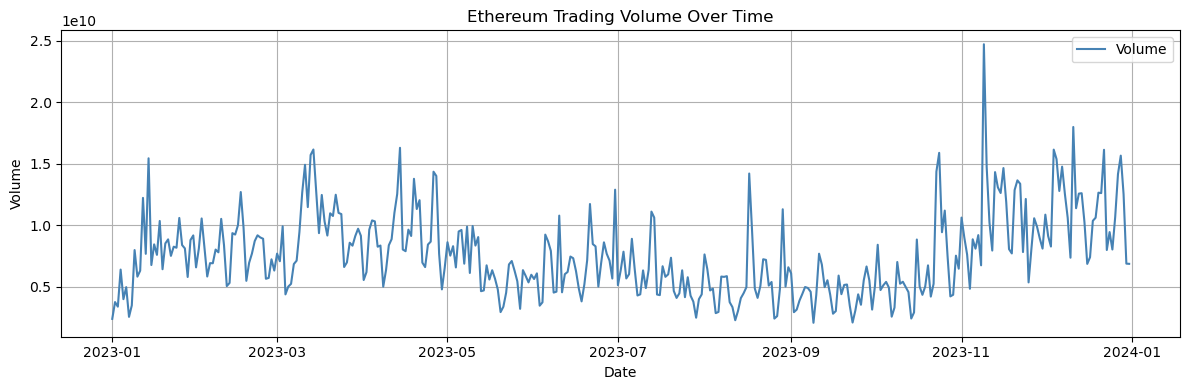

In [5]:
plt.figure(figsize=(12, 4))
plt.plot(eth_data['Volume'], label='Volume', color='steelblue')
plt.title("Ethereum Trading Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("eth_volume_trend.png")
plt.show()

**ADF Stationarity Test**

In [6]:
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Statistic', 'p-value', '# Lags Used', '# Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key, val in result[4].items():
        out[f'Critical Value ({key})'] = val
    print(out)
    if result[1] <= 0.05:
        print(" The series is stationary (reject H0)")
    else:
        print(" The series is NOT stationary (fail to reject H0)")
    print()

In [7]:
adf_test(eth_data['Close'], 'Raw Closing Price')

# First differencing
eth_data['Close_diff'] = eth_data['Close'].diff()
adf_test(eth_data['Close_diff'], 'First Difference of Closing Price')

Augmented Dickey-Fuller Test: Raw Closing Price
ADF Statistic            -2.040433
p-value                   0.269131
# Lags Used               1.000000
# Observations Used     363.000000
Critical Value (1%)      -3.448494
Critical Value (5%)      -2.869535
Critical Value (10%)     -2.571029
dtype: float64
 The series is NOT stationary (fail to reject H0)

Augmented Dickey-Fuller Test: First Difference of Closing Price
ADF Statistic           -21.876160
p-value                   0.000000
# Lags Used               0.000000
# Observations Used     363.000000
Critical Value (1%)      -3.448494
Critical Value (5%)      -2.869535
Critical Value (10%)     -2.571029
dtype: float64
 The series is stationary (reject H0)



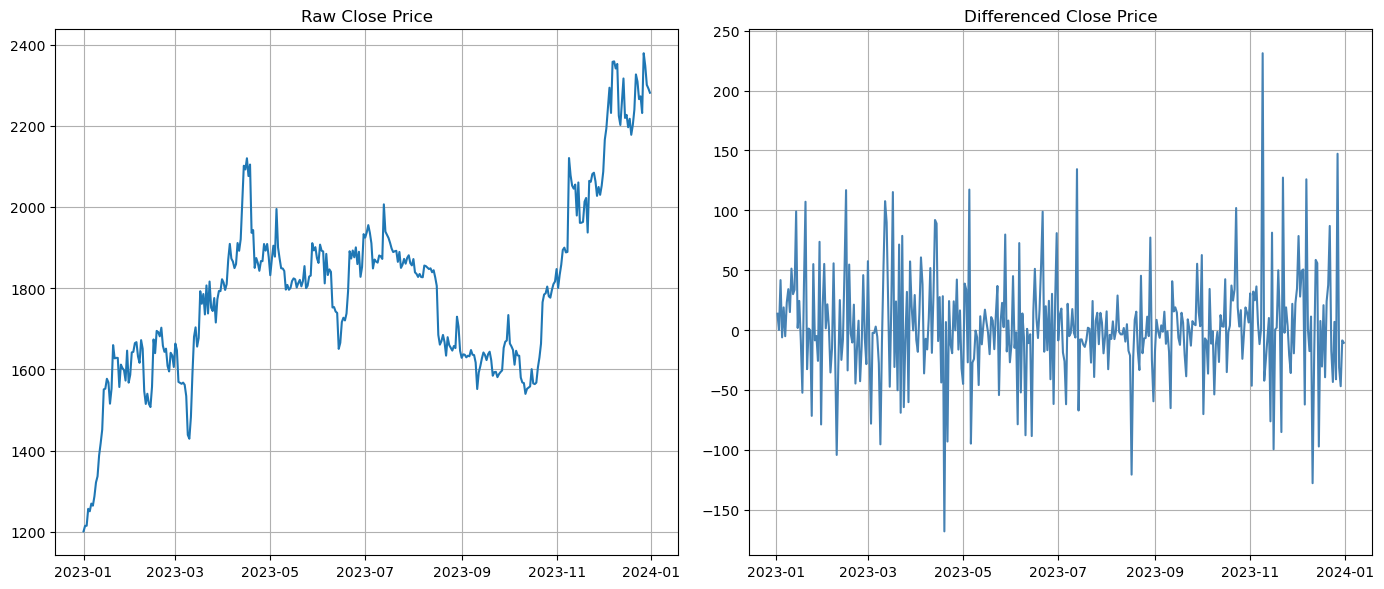

In [9]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(eth_data['Close'], label='Raw Close')
plt.title("Raw Close Price")
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(eth_data['Close_diff'], label='1st Difference', color='steelblue')
plt.title("Differenced Close Price")
plt.grid(True)

plt.tight_layout()
plt.savefig("eth_adf_raw_vs_diff.png")
plt.show()

**ARIMA Model Development**

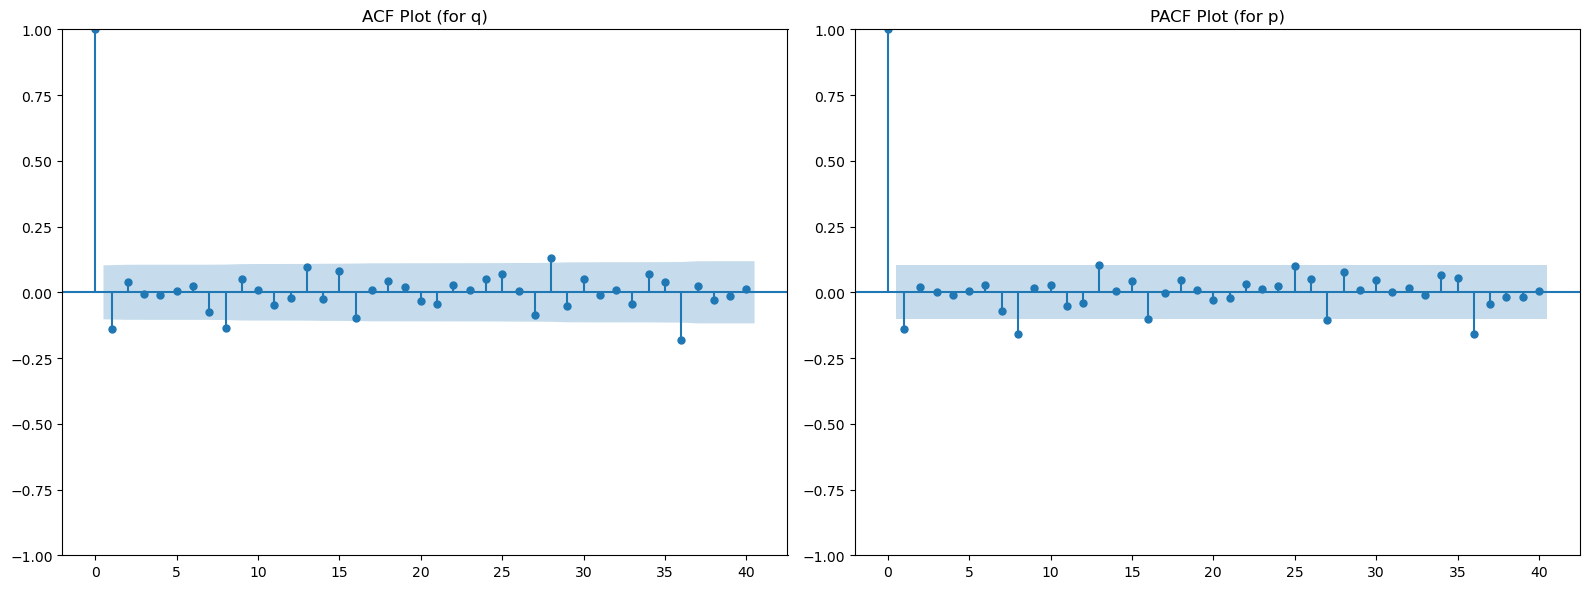

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

plot_acf(eth_data['Close_diff'].dropna(), ax=ax[0], lags=40)
ax[0].set_title('ACF Plot (for q)')

plot_pacf(eth_data['Close_diff'].dropna(), ax=ax[1], method='ywm', lags=40)
ax[1].set_title('PACF Plot (for p)')

plt.tight_layout()
plt.savefig("acf_pacf_eth.png")
plt.show()

**Fit the ARIMA Model**

In [14]:
model = ARIMA(eth_data['Close'], order=(1, 1, 1))
model_fit = model.fit()

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                ETH-USD   No. Observations:                  365
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1893.830
Date:                Thu, 08 May 2025   AIC                           3793.661
Time:                        20:51:24   BIC                           3805.352
Sample:                    01-01-2023   HQIC                          3798.307
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2887      0.385     -0.750      0.453      -1.043       0.466
ma.L1          0.1567      0.397      0.395      0.693      -0.621       0.935
sigma2      1934.7413     89.421     21.636      0.000    1759.480    2110.002
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               157.37
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.95   Skew:                             0.51
Prob(H) (two-sided):                  0.78   Kurtosis:                         6.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
model_212 = ARIMA(eth_data['Close'], order=(2, 1, 2)).fit()
model_212.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                ETH-USD   No. Observations:                  365
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1893.815
Date:                Thu, 08 May 2025   AIC                           3797.630
Time:                        20:52:52   BIC                           3817.116
Sample:                    01-01-2023   HQIC                          3805.375
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9293      4.389     -0.212      0.832      -9.531       7.672
ar.L2         -0.2208      1.131     -0.195      0.845      -2.438       1.997
ma.L1          0.7973      4.391      0.182      0.856      -7.808       9.403
ma.L2          0.1374      0.624      0.220      0.826      -1.086       1.361
sigma2      1934.0996     89.639     21.576      0.000    1758.409    2109.790
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               157.95
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.95   Skew:                             0.52
Prob(H) (two-sided):                  0.78   Kurtosis:                         6.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

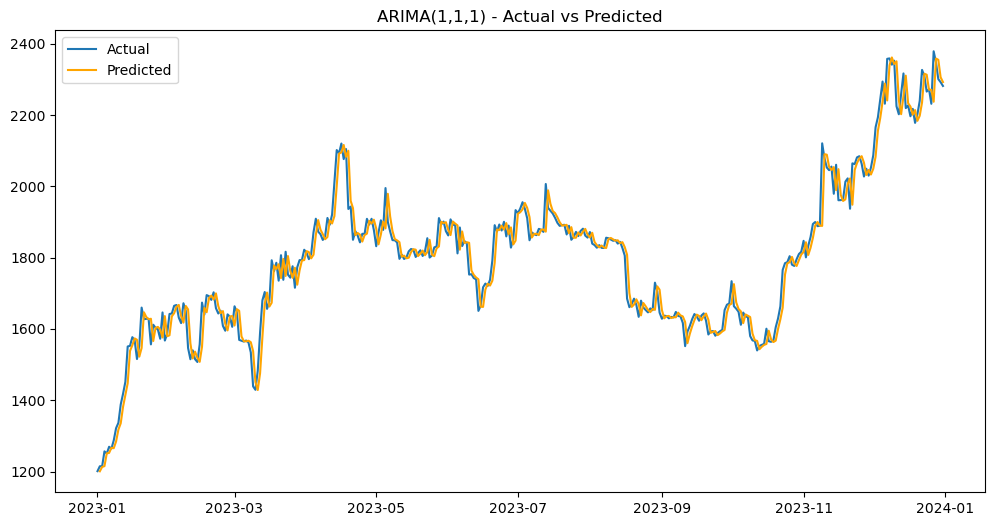

In [16]:
predicted = model_fit.predict(start=1, end=len(eth_data)-1, typ='levels')

# Plot
plt.figure(figsize=(12,6))
plt.plot(eth_data['Close'], label='Actual')
plt.plot(predicted, label='Predicted', color='orange')
plt.legend()
plt.title("ARIMA(1,1,1) - Actual vs Predicted")
plt.show()

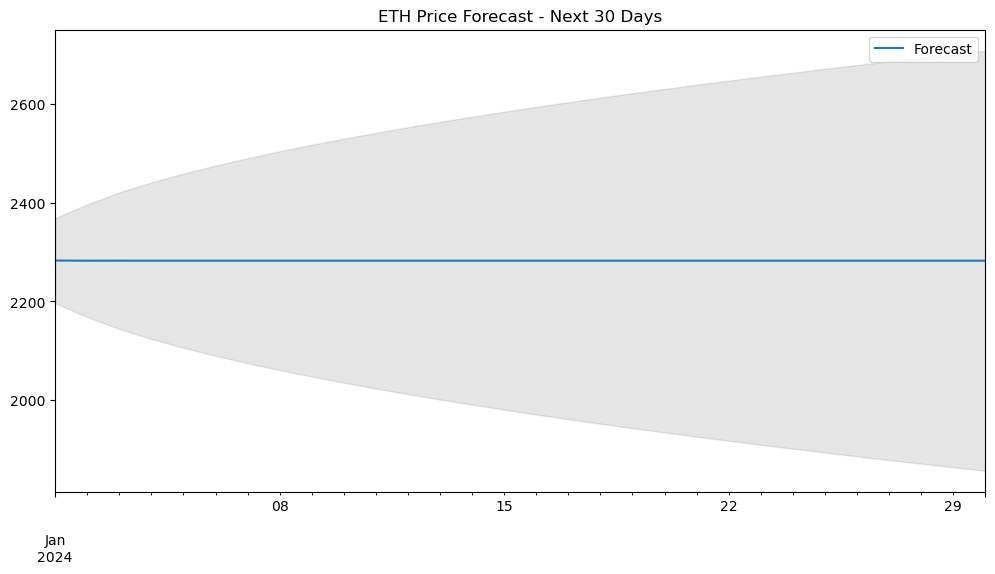

In [17]:
forecast = model_fit.get_forecast(steps=30)
forecast_df = forecast.summary_frame()

# Plot
forecast_df['mean'].plot(label='Forecast', figsize=(12,6))
plt.fill_between(forecast_df.index, 
                 forecast_df['mean_ci_lower'], 
                 forecast_df['mean_ci_upper'], 
                 color='gray', alpha=0.2)
plt.title('ETH Price Forecast - Next 30 Days')
plt.legend()
plt.show()

In [20]:
train = eth_data['Close'][:-30]
test = eth_data['Close'][-30:]

model = ARIMA(train, order=(5,1,2))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                ETH-USD   No. Observations:                  335
Model:                 ARIMA(5, 1, 2)   Log Likelihood               -1723.109
Date:                Thu, 08 May 2025   AIC                           3462.218
Time:                        21:03:32   BIC                           3492.707
Sample:                    01-01-2023   HQIC                          3474.374
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4248      0.123     11.571      0.000       1.183       1.666
ar.L2         -0.6322      0.131     -4.824      0.000      -0.889      -0.375
ar.L3         -0.1575      0.122     -1.296      0.195      -0.396       0.081
ar.L4         -0.0021      0.122     -0.017      0.986      -0.242       0.237
ar.L5         -0.0099      0.072     -0.136      0.892      -0.152       0.132
ma.L1         -1.5829      0.116    -13.638      0.000      -1.810      -1.355
ma.L2          0.9128      0.120      7.595      0.000       0.677       1.148
sigma2      1795.5870     84.355     21.286      0.000    1630.254    1960.920
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               210.62
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                             0.58
Prob(H) (two-sided):                  0.08   Kurtosis:                         6.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

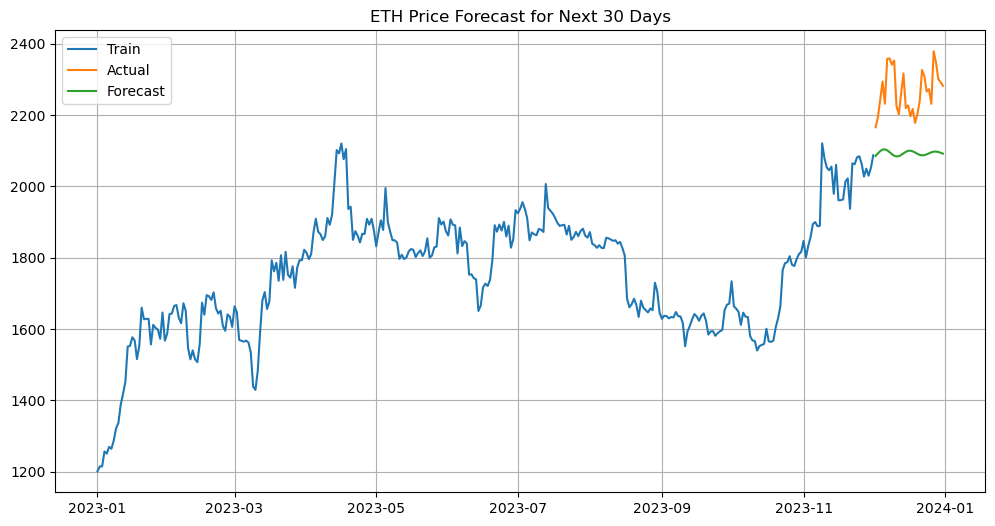

In [21]:
forecast = model_fit.forecast(steps=30)
forecast.index = test.index

plt.figure(figsize=(12,6))
plt.plot(train, label='Train')
plt.plot(test, label='Actual')
plt.plot(forecast, label='Forecast')
plt.legend()
plt.title('ETH Price Forecast for Next 30 Days')
plt.grid()
plt.savefig('ETH_Forecast.png')
plt.show()

In [22]:
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = mean_absolute_percentage_error(test, forecast)

print("\nModel Evaluation:")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape*100:.2f}%")


Model Evaluation:
RMSE: 184.09
MAPE: 7.61%
